<p style="font-size:29px"><strong>Retail Marketing Individual Assignment</strong></p>

Analysis notebook.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Dataset-characteristics" data-toc-modified-id="Dataset-characteristics-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Dataset characteristics</a></span></li><li><span><a href="#Dataset-features" data-toc-modified-id="Dataset-features-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Dataset features</a></span></li><li><span><a href="#Seasonality" data-toc-modified-id="Seasonality-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Seasonality</a></span></li></ul></li><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data Preparation</a></span><ul class="toc-item"><li><span><a href="#Log-Transformation" data-toc-modified-id="Log-Transformation-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Log Transformation</a></span></li><li><span><a href="#Seasonal-Dummy-Variables" data-toc-modified-id="Seasonal-Dummy-Variables-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Seasonal Dummy Variables</a></span></li><li><span><a href="#Binary-Variables" data-toc-modified-id="Binary-Variables-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Binary Variables</a></span></li><li><span><a href="#Train/test-Split" data-toc-modified-id="Train/test-Split-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Train/test Split</a></span></li></ul></li><li><span><a href="#SCAN*PRO-Regression" data-toc-modified-id="SCAN*PRO-Regression-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>SCAN*PRO Regression</a></span><ul class="toc-item"><li><span><a href="#Model-1" data-toc-modified-id="Model-1-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Model 1</a></span></li><li><span><a href="#Model-Diagnostics" data-toc-modified-id="Model-Diagnostics-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Model Diagnostics</a></span></li></ul></li><li><span><a href="#Retrain-Models-on-all-data" data-toc-modified-id="Retrain-Models-on-all-data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Retrain Models on all data</a></span></li><li><span><a href="#Latex-Outputs-For-Report" data-toc-modified-id="Latex-Outputs-For-Report-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Latex Outputs For Report</a></span></li></ul></div>

# Imports

In [1]:
import re
import pandas as pd
import numpy as np
import scipy

import calendar

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.nonparametric.smoothers_lowess import  lowess

from sklearn.model_selection import train_test_split

from IPython.core.display import display, HTML

**Custom Python Files**

Please see `constants.py` and `utils.py` for custom functions.
All constants from `constants.py` are in upper case

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#custom python files
from utils import *
from constants import *

In [4]:
#visualisation libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

#matplotlib styling
plt.rcParams['font.family'] = 'serif'

In [5]:
pd.set_option('display.max_columns', 500)

# Load Data

The data covers weekly sales, price, display and feature information for three brands of beer for the supermarket chain Dominicks over 227 weeks. 

Retailer margin and wholesale price for each brand is also included.

In [6]:
data = pd.read_excel(f"{DATA_FOLDER}/beer_data_chicago_Dominicks.xlsx", index_col='Week ')

**Add unit sales**

The SCAN\*PRO model estimates *unit* sales rather than \\$ sales. Therefore we need to create a new feature which is the estimated unit sales of each beer brand. This can be created by dividing sales ($) (SALESBRAND\*) by the average price in the week (PRICEBRAND\*) and rounding to the nearest integer.

In [7]:
brand_sales_cols = ['SALESBRAND1','SALESBRAND2','SALESBRAND3']
brand_price_cols = ['PRICEBRAND1','PRICEBRAND2','PRICEBRAND3']


#calculate units (round to nearest integer)
for s,p in zip(brand_sales_cols,brand_price_cols):
    data[f"UNITSBRAND{s[-1]}"] = (data[s]/data[p]).astype(int)

**Add timeseries dates**

The data is a time series. Currently the weeks are expressed as a incrementing series from 1 to 227. In the [literature](https://pubsonline.informs.org/doi/10.1287/mnsc.1040.0225) it is stated that the dataset begins in June 1989. It will be assumed that the data starts from week 1 (starting on a Sunday) of June 1989. Therefore the index will be converted to the actual dates and new column will be added to the dataset which describes the month of the year (this will be important for incorporating seasonality into the model).

In [8]:
# convert index to datetime
data.index = pd.date_range(start='1989/06/01', periods=len(data), freq='W')
data['month'] = data.index.month_name()

**Final data**

In [9]:
#assert no missing data
assert data.isnull().sum().sum() == 0

print(f"There are {data.shape[0]} datapoints")
data.head()

There are 227 datapoints


,CategorySales,PRICEBRAND1,PRICEBRAND2,PRICEBRAND3,display_brand1,display_brand2,display_brand3,FEATUREBRAND1,FEATUREBRAND2,FEATUREBRAND3,RETAILERMARGINBRAND1,RETAILERMARGINBRAND2,RETAILERMARGINBRAND3,SALESBRAND1,SALESBRAND2,SALESBRAND3,WHOLESALEPRICE1,WHOLESALEPRICE2,WHOLESALEPRICE3,UNITSBRAND1,UNITSBRAND2,UNITSBRAND3,month
1989-06-04,62929.477667,5.005623,4.562936,4.293051,0.000,0.124,0.092,0.0,0.0,0.0,0.120878,0.136304,0.156036,24321.600000,27790.157667,10817.720000,4.011377,4.323338,3.623182,4858,6090,2519,June
1989-06-11,70907.531666,4.759082,4.666338,4.342844,0.234,0.075,0.089,0.0,0.0,0.0,0.135090,0.089354,0.157650,33005.983333,26466.924333,11434.624000,4.035964,4.333838,3.658193,6935,5671,2632,June
1989-06-18,67031.204999,4.630858,4.770684,4.913317,0.256,0.119,0.044,0.0,0.0,0.0,0.119915,0.081313,0.123846,34129.983333,26000.576333,6900.645333,4.198608,4.254309,4.304820,7370,5450,1404,June
1989-06-25,83289.667166,4.222040,4.266464,4.934866,0.105,0.120,0.016,0.0,0.0,0.0,0.129831,0.166255,0.131854,41453.750000,35708.431833,6127.485333,3.712543,3.520105,4.284186,9818,8369,1241,June
1989-07-02,122057.548834,4.105199,4.103394,4.905153,0.180,0.092,0.000,0.0,0.0,0.0,0.133630,0.124810,0.130308,67620.016667,46842.793500,7594.738667,3.555056,3.592828,4.265970,16471,11415,1548,July


# EDA

## Dataset characteristics

The main features of the dataset available for modelling include ([Srinivasan et. al, 2002](https://pubsonline.informs.org/doi/10.1287/mnsc.1040.0225)):
- PRICEBRAND*: the average price of the beer brand during the week
- display_brand*: the percentage of stock keeping units which were put on display
- FEATUREBRAND*: the percentage of stock keeping units which were 'featured' during the week
- REATAILERMARGINBRAND*: the percentage profit (margin) the retailer made on the sale of each product
- SALESBRAND*: the sales in dollars (\\$) 
- WHOLESALEPRICE*: the wholesale price of the product
- UNITSBRAND*: the number of units sold in each week

In [10]:
#descriptive statistics for the dataframe
data.describe().T

,count,mean,std,min,25%,50%,75%,max
CategorySales,227.0,62567.408851,18223.926584,37429.139167,49491.279833,58811.270167,70813.822832,146302.515499
PRICEBRAND1,227.0,4.756340,0.243022,4.104838,4.592634,4.767329,4.922494,5.325438
PRICEBRAND2,227.0,4.536854,0.329527,3.221186,4.347520,4.519291,4.743886,5.408419
PRICEBRAND3,227.0,4.644886,0.258895,3.882713,4.466815,4.643807,4.849372,5.152313
display_brand1,227.0,0.182921,0.091583,0.000000,0.121500,0.172000,0.245500,0.499000
display_brand2,227.0,0.119185,0.034654,0.029000,0.093500,0.118000,0.139000,0.242000
display_brand3,227.0,0.135416,0.092158,0.000000,0.063500,0.134000,0.197000,0.461000
FEATUREBRAND1,227.0,0.007533,0.022433,0.000000,0.000000,0.000000,0.001000,0.128000
FEATUREBRAND2,227.0,0.002048,0.004879,0.000000,0.000000,0.000000,0.001000,0.027000
FEATUREBRAND3,227.0,0.001238,0.009878,0.000000,0.000000,0.000000,0.000000,0.116000


## Dataset features

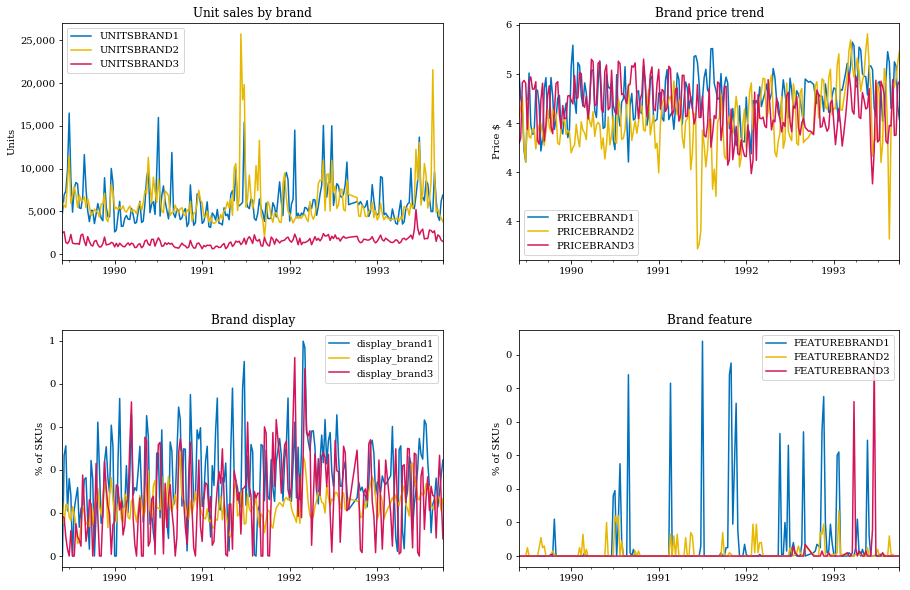

In [11]:
cols = data.columns
brand_units_cols = get_cols(r"UNITS", cols)
brand_price_cols = get_cols(r"^PRICE", cols)
brand_display_cols = get_cols(r"display", cols)
brand_feature_cols = get_cols(r"FEATURE", cols)
brand_wholesale_cols = get_cols(r"WHOLESALE", cols)


fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(15,10))

axs[0][0] = plot_cols(data, brand_units_cols, axs[0][0], "Unit sales by brand", "Units")
axs[0][1] = plot_cols(data, brand_price_cols, axs[0][1], "Brand price trend", "Price $")
axs[1][0] = plot_cols(data, brand_display_cols, axs[1][0], "Brand display", "% of SKUs")
axs[1][1] = plot_cols(data, brand_feature_cols, axs[1][1], "Brand feature", "% of SKUs")


plt.subplots_adjust(hspace=0.3)

plt.savefig(f"{VISUALISATION_FOLDER}/eda_plots.png")
plt.show()

Brand 1 and 2 are the most popular beer brands with similar weekly unit sales and high variation from week to week. Whereas brand 3 has a much more consistent but lower sales volume. The retail sales price of each brand is similar and hovers between qpproximately \\$4 and \\$5. At least a certain percentage of each brand is on 'display' each week with brand 1 generally having the largest percentage of stock keeping units on display. Beer brands are 'featured' much less frequently.

The SCAN\*PRO model is sensitive to bias in the estimated parameters if the variables are endogenous. For example, the price coefficient may be biased if store managers set their prices based on the level of sales of the product. If this is the case an instrumental variable approach can be taken using wholesale prices instead which are not controlled by the manager.

The potential endogeneity problem will be investigated later in the analysis if required.

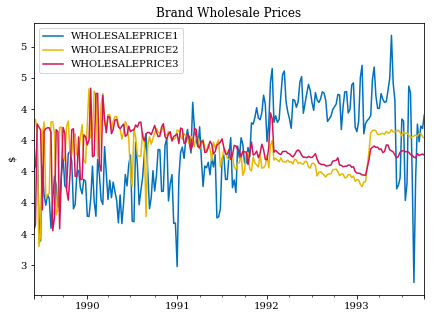

In [12]:
fig, ax = plt.subplots(nrows=1, figsize=(7,5))
plot_cols(data, brand_wholesale_cols, ax, title='Brand Wholesale Prices',ylabel='$')
plt.show()

## Seasonality

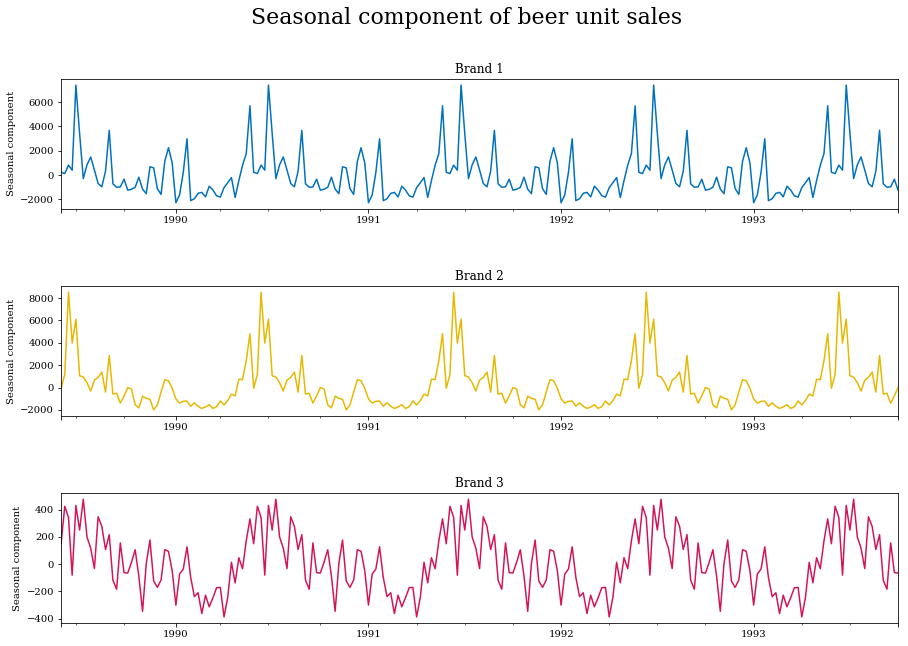

In [13]:
brand1_seasonality = seasonal_decompose(data['UNITSBRAND1'], model='additive', period=52)
brand2_seasonality = seasonal_decompose(data['UNITSBRAND2'], model='additive', period=52)
brand3_seasonality = seasonal_decompose(data['UNITSBRAND3'], model='additive', period=52)

seasonal_results = [brand1_seasonality,brand2_seasonality,brand3_seasonality]


fig, axs = plt.subplots(3,1, figsize=(15,10))

for i, (result, ax) in enumerate(zip(seasonal_results,axs)):
    result.seasonal.plot(ax=ax, color=BRAND_COLORS[i])
    ax.set_title(f"Brand {i+1}")
    ax.set_ylabel("Seasonal component")

plt.suptitle("Seasonal component of beer unit sales", y=0.98, fontsize=22)

plt.subplots_adjust(hspace=0.6)
plt.savefig(f"{VISUALISATION_FOLDER}/seasonal_plots.png")
plt.show()

All three brands exhibit a significant seasonal impact on unit sales. This will need to be incorporated into the regression model. 

Sales of beer are much higher in the summer months (May-September) compared to the winter months. There also appears to be a small peak in November/December each year probably as a result of the Thanksgiving/Christmas holiday season.

# Data Preparation

Cleaning and transforming the data for modelling.

The SCAN\*PRO model is a multiplicative model, however, the parameters can be log transformed to create a linear model which is easier to estimate.

Following the EDA, a series of new/transformed features will be added to the dataset to be used in the regression model. Subsets of these features will be chosen for the final regression model:
1. A log transformation will be applied to each column so the model can be expressed as a linear function. Note that due to the presence of zero values, a log(x+1) transformation will be applied.
2. Seasonal dummy variables will be added to account for the seasonality in the unit sales
3. The 'FEATUREDBRAND*' columns will be converted into a binary variable as most of the values are zero


## Log Transformation

In [14]:
#apply log transofation to all numeric columns
log_transform = data.select_dtypes(exclude='object').apply(lambda x: np.log(x+1),axis=1)

#add 'log_' prefix to column names
log_transform = log_transform.add_prefix('log_')

#add log_ columns to the dataset
data[log_transform.columns] = log_transform

## Seasonal Dummy Variables

In [15]:
#drop one dummy variable
data = pd.get_dummies(data, columns=['month'],drop_first=True, prefix='', prefix_sep='')

## Binary Variables

In [16]:
binary_col_names = ['binary_' + col for col in brand_feature_cols]
binary_col_names

['binary_FEATUREBRAND1', 'binary_FEATUREBRAND2', 'binary_FEATUREBRAND3']

In [17]:
data[binary_col_names] = data[brand_feature_cols].applymap(lambda x: 1 if x>0.01 else 0)

In [18]:
data.head(10)

,CategorySales,PRICEBRAND1,PRICEBRAND2,PRICEBRAND3,display_brand1,display_brand2,display_brand3,FEATUREBRAND1,FEATUREBRAND2,FEATUREBRAND3,RETAILERMARGINBRAND1,RETAILERMARGINBRAND2,RETAILERMARGINBRAND3,SALESBRAND1,SALESBRAND2,SALESBRAND3,WHOLESALEPRICE1,WHOLESALEPRICE2,WHOLESALEPRICE3,UNITSBRAND1,UNITSBRAND2,UNITSBRAND3,log_CategorySales,log_PRICEBRAND1,log_PRICEBRAND2,log_PRICEBRAND3,log_display_brand1,log_display_brand2,log_display_brand3,log_FEATUREBRAND1,log_FEATUREBRAND2,log_FEATUREBRAND3,log_RETAILERMARGINBRAND1,log_RETAILERMARGINBRAND2,log_RETAILERMARGINBRAND3,log_SALESBRAND1,log_SALESBRAND2,log_SALESBRAND3,log_WHOLESALEPRICE1,log_WHOLESALEPRICE2,log_WHOLESALEPRICE3,log_UNITSBRAND1,log_UNITSBRAND2,log_UNITSBRAND3,August,December,February,January,July,June,March,May,November,October,September,binary_FEATUREBRAND1,binary_FEATUREBRAND2,binary_FEATUREBRAND3
1989-06-04,62929.477667,5.005623,4.562936,4.293051,0.000,0.124,0.092,0.0,0.000,0.0,0.120878,0.136304,0.156036,24321.600000,27790.157667,10817.720000,4.011377,4.323338,3.623182,4858,6090,2519,11.049786,1.792696,1.716126,1.666395,0.000000,0.116894,0.088011,0.0,0.000000,0.0,0.114112,0.127781,0.144997,10.099161,10.232473,9.289033,1.611711,1.672100,1.531083,8.488588,8.714568,7.832014,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1989-06-11,70907.531666,4.759082,4.666338,4.342844,0.234,0.075,0.089,0.0,0.000,0.0,0.135090,0.089354,0.157650,33005.983333,26466.924333,11434.624000,4.035964,4.333838,3.658193,6935,5671,2632,11.169146,1.750778,1.734543,1.675758,0.210261,0.072321,0.085260,0.0,0.000000,0.0,0.126712,0.085585,0.146392,10.404474,10.183689,9.344489,1.616605,1.674071,1.538628,8.844481,8.643297,7.875879,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1989-06-18,67031.204999,4.630858,4.770684,4.913317,0.256,0.119,0.044,0.0,0.000,0.0,0.119915,0.081313,0.123846,34129.983333,26000.576333,6900.645333,4.198608,4.254309,4.304820,7370,5450,1404,11.112928,1.728262,1.752791,1.777207,0.227932,0.112435,0.043059,0.0,0.000000,0.0,0.113253,0.078176,0.116757,10.437961,10.165912,8.839515,1.648391,1.659048,1.668616,8.905309,8.603554,7.247793,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1989-06-25,83289.667166,4.222040,4.266464,4.934866,0.105,0.120,0.016,0.0,0.000,0.0,0.129831,0.166255,0.131854,41453.750000,35708.431833,6127.485333,3.712543,3.520105,4.284186,9818,8369,1241,11.330092,1.652888,1.661359,1.780845,0.099845,0.113329,0.015873,0.0,0.000000,0.0,0.122068,0.153798,0.123857,10.632358,10.483170,8.720703,1.550228,1.508535,1.664719,9.192075,9.032409,7.124478,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1989-07-02,122057.548834,4.105199,4.103394,4.905153,0.180,0.092,0.000,0.0,0.000,0.0,0.133630,0.124810,0.130308,67620.016667,46842.793500,7594.738667,3.555056,3.592828,4.265970,16471,11415,1548,11.712256,1.630259,1.629906,1.775825,0.165514,0.088011,0.000000,0.0,0.000000,0.0,0.125425,0.117614,0.122490,11.121674,10.754574,8.935343,1.516238,1.524496,1.661265,9.709417,9.342771,7.345365,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1989-07-09,79422.435333,4.630080,4.727706,4.437782,0.141,0.082,0.059,0.0,0.005,0.0,0.146246,0.085801,0.153910,41049.033333,28123.130000,10250.272000,4.036299,4.232816,3.754761,8865,5948,2309,11.282549,1.728124,1.745315,1.693371,0.131905,0.078811,0.057325,0.0,0.004988,0.0,0.136492,0.082318,0.143156,10.622547,10.244383,9.235157,1.616671,1.654950,1.559146,9.089979,8.690978,7.745003,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1989-07-16,60767.206834,5.010509,4.363861,4.920926,0.000,0.115,0.000,0.0,0.000,0.0,0.117737,0.138321,0.134765,24631.366667,29716.157500,6419.682667,3.850075,4.317448,4.257756,4915,6809,1304,11.014822,1.793509,1.679684,1.778493,0.000000,0.108854,0.000000,0.0,0.000000,0.0,0.111306,0.129555,0.126426,10.111817,10.299480,8.767280,1.578994,1.670994,1.659704,8.500250,8.826147,7.173958,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1989-07-23,74765.591500,4.483190,4.349144,4.970656,0.108,0.097,0.000,0.0,0.000,0.0,0.129925,0.146091,0.140025,34437.516667,34175.429500,6152.645333,3.784082,3.828238,4.274641,7681,7857,1237,11.222126,1.701687,1.676937,1.786857,0.102557,0.092579,0.000000,0.0,0

## Train/test Split

In [19]:
TRAIN_SIZE = 0.8
SEED = 42

In [20]:
train, test = train_test_split(data, train_size=0.75, shuffle=True, random_state=SEED)

# SCAN\*PRO Regression

**Create lists of feature columns**

In [21]:
months = [calendar.month_name[i] for i in range(1,13)]
seasonal_cols = [col for col in data.columns if col in months]

binary_feature_cols = get_cols('^binary', data.columns)

log_display_cols = get_cols('^log_display', data.columns)

log_price_cols = get_cols('^log_PRICE', data.columns)

## Model 1
- Target: log_Units  
- Features:
    - Seasonal dummy variables
    - Binary FEATURED variable
    - log price, log display

In [22]:
model1_features = (
    log_price_cols + 
    log_display_cols + 
    binary_feature_cols + 
    seasonal_cols
)

In [23]:
brand1_model1_train = estimate_ols(target_col='log_UNITSBRAND1',
                                   feature_cols=model1_features,
                                   df=train,
                                   model_name='brand1_model1_train')


brand2_model1_train = estimate_ols(target_col='log_UNITSBRAND2',
                                   feature_cols=model1_features,
                                   df=train,
                                   model_name='brand2_model1_train')

brand3_model1_train = estimate_ols(target_col='log_UNITSBRAND3',
                                   feature_cols=model1_features,
                                   df=train,
                                   model_name='brand3_model1_train')

train_models = [brand1_model1_train, brand2_model1_train, brand3_model1_train]

C:\Users\westj\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [24]:
for i, model in enumerate(train_models):
    display(HTML(f"<strong>Brand {i+1}</strong>"))
    print(model.summary())
    print("*"*100)
    print("\n")

                            OLS Regression Results                            
Dep. Variable:        log_UNITSBRAND1   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     28.41
Date:                Fri, 10 Apr 2020   Prob (F-statistic):           6.37e-41
Time:                        13:49:46   Log-Likelihood:                 69.627
No. Observations:                 170   AIC:                            -97.25
Df Residuals:                     149   BIC:                            -31.40
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   18.8241 

                            OLS Regression Results                            
Dep. Variable:        log_UNITSBRAND2   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     32.35
Date:                Fri, 10 Apr 2020   Prob (F-statistic):           3.38e-44
Time:                        13:49:46   Log-Likelihood:                 90.869
No. Observations:                 170   AIC:                            -139.7
Df Residuals:                     149   BIC:                            -73.89
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   16.5339 

                            OLS Regression Results                            
Dep. Variable:        log_UNITSBRAND3   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     32.60
Date:                Fri, 10 Apr 2020   Prob (F-statistic):           2.14e-44
Time:                        13:49:46   Log-Likelihood:                 81.306
No. Observations:                 170   AIC:                            -120.6
Df Residuals:                     149   BIC:                            -54.76
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   14.9059 

## Model Diagnostics

https://towardsdatascience.com/going-from-r-to-python-linear-regression-diagnostic-plots-144d1c4aa5a

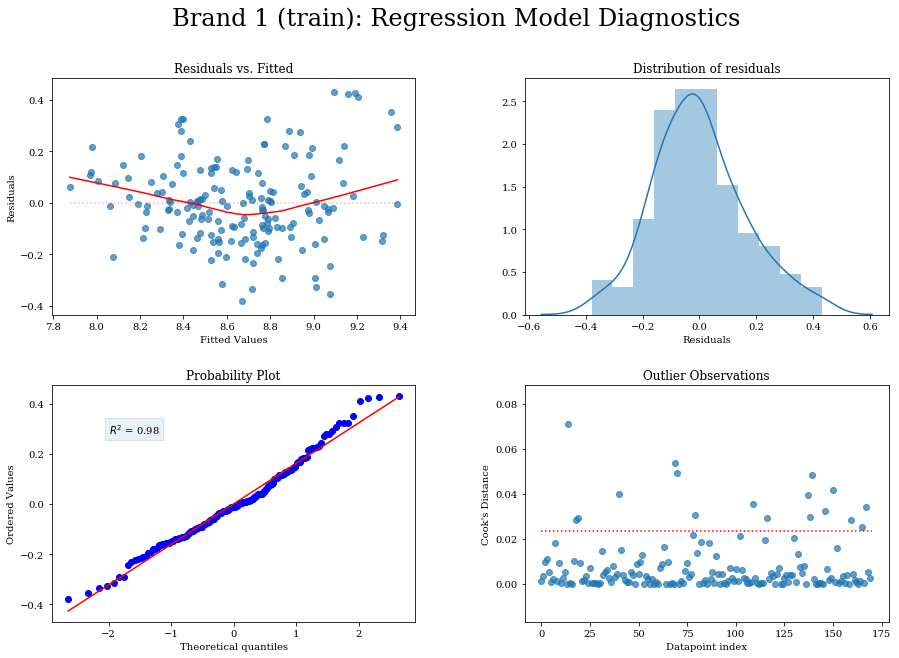

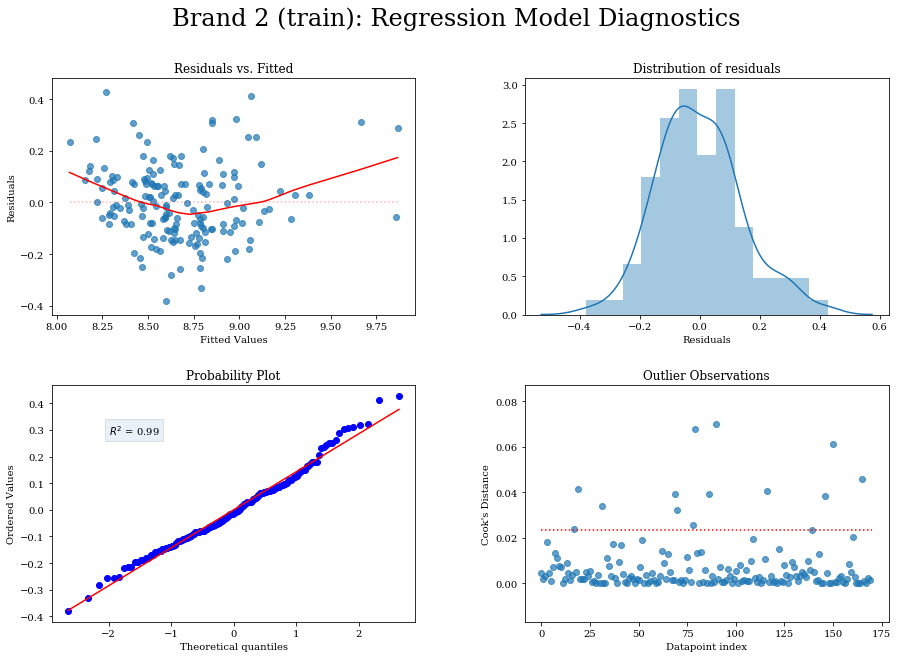

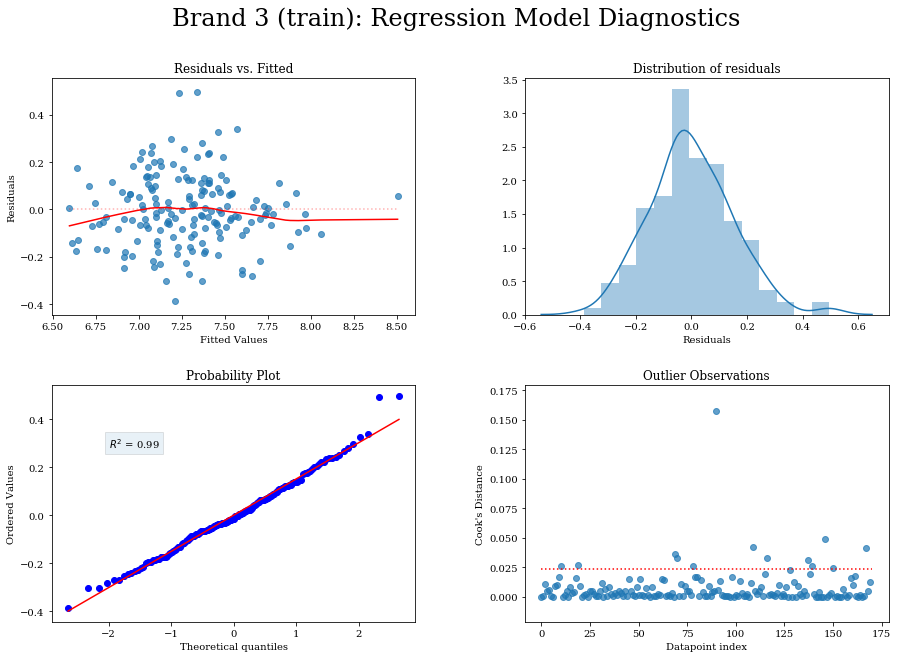

In [25]:
plot_diagnostics(brand1_model1_train, "Brand 1 (train)")
plot_diagnostics(brand2_model1_train, "Brand 2 (train)")
plot_diagnostics(brand3_model1_train, "Brand 3 (train)")

------------------
# Retrain Models on all data

----------

# Latex Outputs For Report

Copy and paste output into the report

In [26]:
from IPython.display import display, Markdown, Latex, HTML
from stargazer.stargazer import Stargazer


In [27]:
display(HTML("<h3>Brand 1 model"))
#Latex(Stargazer([model_b1]).render_latex())